In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from matplotlib import dates
from datetime import datetime
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn import neural_network
import warnings
warnings.filterwarnings('ignore')

In [3]:
SPY = yf.Ticker("SPY")

# get stock info
#SPY.info

# get historical market data
hist = SPY.history(period="max",interval='1d',)

In [4]:
df_drop = hist.drop('Dividends', axis=1)
df = df_drop.drop('Stock Splits', axis=1)

In [5]:
df=df.reset_index()
df

,Date,Open,High,Low,Close,Volume,Capital Gains
0,1993-01-29 00:00:00-05:00,25.236160,25.236160,25.110607,25.218224,1003200,0.0
1,1993-02-01 00:00:00-05:00,25.236156,25.397581,25.236156,25.397581,480500,0.0
2,1993-02-02 00:00:00-05:00,25.379647,25.469327,25.325838,25.451391,201300,0.0
3,1993-02-03 00:00:00-05:00,25.487274,25.738380,25.469338,25.720444,529400,0.0
4,1993-02-04 00:00:00-05:00,25.810130,25.881874,25.523151,25.828066,531500,0.0
...,...,...,...,...,...,...,...
7578,2023-03-06 00:00:00-05:00,405.049988,407.450012,404.010010,404.470001,72795900,0.0
7579,2023-03-07 00:00:00-05:00,404.420013,404.670013,397.630005,398.269989,108310600,0.0
7580,2023-03-08 00:00:00-05:00,398.390015,399.709991,396.589996,398.920013,74746600,0.0
7581,2023-03-09 00:00:00-05:00,399.739990,401.480011,390.529999,391.559998,111945300,0.0


In [6]:
OHLC_avg = df[['Close', 'Open', 'High', 'Low']].mean(axis = 1)

OHLC_avg

0        25.200287
1        25.316868
2        25.406551
3        25.603859
4        25.760805
           ...    
7578    405.245003
7579    401.247505
7580    398.402504
7581    395.827499
7582    388.595001
Length: 7583, dtype: float64

In [7]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [8]:
train_OHLC = int(len(OHLC_avg) * 0.80)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [9]:
step_size = 1

In [10]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [11]:
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
6064/6064 [==============================] - 22s 3ms/step - loss: 5.3336e-04
Epoch 2/5
6064/6064 [==============================] - 21s 3ms/step - loss: 1.0650e-05
Epoch 3/5
6064/6064 [==============================] - 24s 4ms/step - loss: 1.0313e-05
Epoch 4/5
6064/6064 [==============================] - 20s 3ms/step - loss: 1.0625e-05
Epoch 5/5
6064/6064 [==============================] - 24s 4ms/step - loss: 1.0204e-05


In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

48/48 [==============================] - 0s 2ms/step


In [15]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.83
Test RMSE: 12.45


In [17]:
 mean_absolute_error(trainY[0],trainPredict[:,0])

1.6491921927030768

In [18]:
explained_variance_score(trainY[0],trainPredict[:,0])

0.9995130844995802

In [19]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [20]:
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

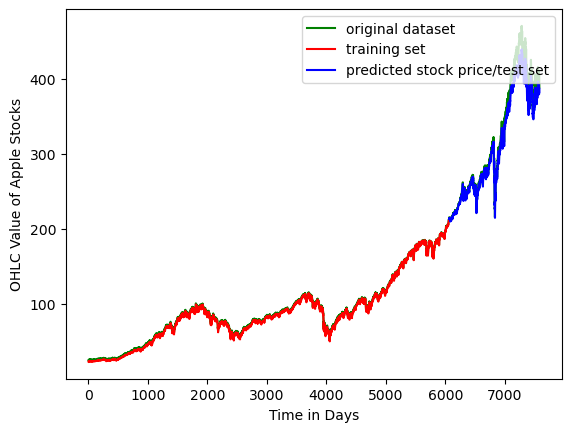

In [21]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [22]:
model3=Sequential()
model3.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model3.add(LSTM(16))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam') 

new_OHLC_avg=OHLC_avg.copy()

for i in range(5):
    trainX3, trainY3=new_dataset(new_OHLC_avg, 1)
    trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
    model3.fit(trainX3, trainY3, epochs=5, batch_size=1, verbose=2)
    
    last_val = new_OHLC_avg[-1]
    next_val = model3.predict(np.reshape(last_val, (1,1,1)))
    new_OHLC_avg = np.append(new_OHLC_avg, next_val[0])
    new_OHLC_avg=new_OHLC_avg.reshape(-1,1)

Epoch 1/5
7581/7581 - 21s - loss: 20710.3125 - 21s/epoch - 3ms/step
Epoch 2/5
7581/7581 - 20s - loss: 11885.0498 - 20s/epoch - 3ms/step
Epoch 3/5
7581/7581 - 21s - loss: 7532.6670 - 21s/epoch - 3ms/step
Epoch 4/5
7581/7581 - 19s - loss: 4881.5991 - 19s/epoch - 3ms/step
Epoch 5/5
7581/7581 - 21s - loss: 3199.7747 - 21s/epoch - 3ms/step
1/1 [==============================] - 1s 1s/step
Epoch 1/5
7582/7582 - 27s - loss: 2128.9260 - 27s/epoch - 4ms/step
Epoch 2/5
7582/7582 - 24s - loss: 1397.3112 - 24s/epoch - 3ms/step
Epoch 3/5
7582/7582 - 22s - loss: 959.2197 - 22s/epoch - 3ms/step
Epoch 4/5
7582/7582 - 20s - loss: 720.7673 - 20s/epoch - 3ms/step
Epoch 5/5
7582/7582 - 24s - loss: 482.1232 - 24s/epoch - 3ms/step
1/1 [==============================] - 0s 34ms/step
Epoch 1/5
7583/7583 - 29s - loss: 501.8268 - 29s/epoch - 4ms/step
Epoch 2/5
7583/7583 - 25s - loss: 208.3768 - 25s/epoch - 3ms/step
Epoch 3/5
7583/7583 - 25s - loss: 259.2370 - 25s/epoch - 3ms/step
Epoch 4/5
7583/7583 - 25s - los

In [23]:
next_val = scaler.inverse_transform(new_OHLC_avg[-90:])
OHLC_avg=scaler.inverse_transform(OHLC_avg)

In [24]:
df_new = pd.DataFrame(next_val)
df_old =  pd.DataFrame(OHLC_avg)

In [25]:
df_full = df_old.append(df_new)

In [26]:
df_reset = df_full.reset_index()
df_ful = df_reset.drop(['index'], axis=1)

In [27]:
df

,Date,Open,High,Low,Close,Volume,Capital Gains
0,1993-01-29 00:00:00-05:00,25.236160,25.236160,25.110607,25.218224,1003200,0.0
1,1993-02-01 00:00:00-05:00,25.236156,25.397581,25.236156,25.397581,480500,0.0
2,1993-02-02 00:00:00-05:00,25.379647,25.469327,25.325838,25.451391,201300,0.0
3,1993-02-03 00:00:00-05:00,25.487274,25.738380,25.469338,25.720444,529400,0.0
4,1993-02-04 00:00:00-05:00,25.810130,25.881874,25.523151,25.828066,531500,0.0
...,...,...,...,...,...,...,...
7578,2023-03-06 00:00:00-05:00,405.049988,407.450012,404.010010,404.470001,72795900,0.0
7579,2023-03-07 00:00:00-05:00,404.420013,404.670013,397.630005,398.269989,108310600,0.0
7580,2023-03-08 00:00:00-05:00,398.390015,399.709991,396.589996,398.920013,74746600,0.0
7581,2023-03-09 00:00:00-05:00,399.739990,401.480011,390.529999,391.559998,111945300,0.0


In [28]:
from matplotlib.pyplot import figure

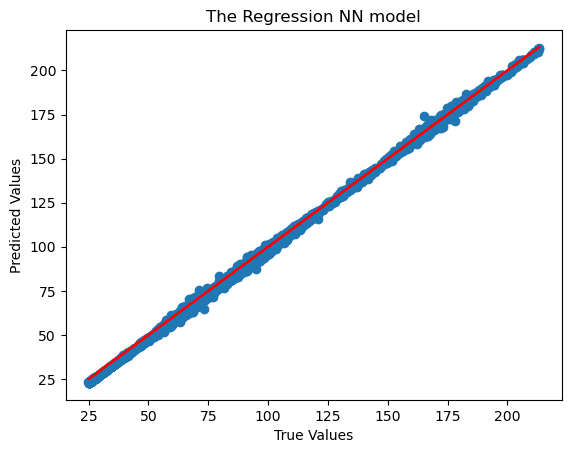

In [29]:
plt.scatter(trainY[0],trainPredict[:,0])
plt.plot(trainY[0],trainY[0],'r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('The Regression NN model')
plt.show()

In [30]:
df_ful[-6:]

,0
7667,173153.128904
7668,105034.316335
7669,107119.023109
7670,107042.421567
7671,104047.830136
7672,103094.654867


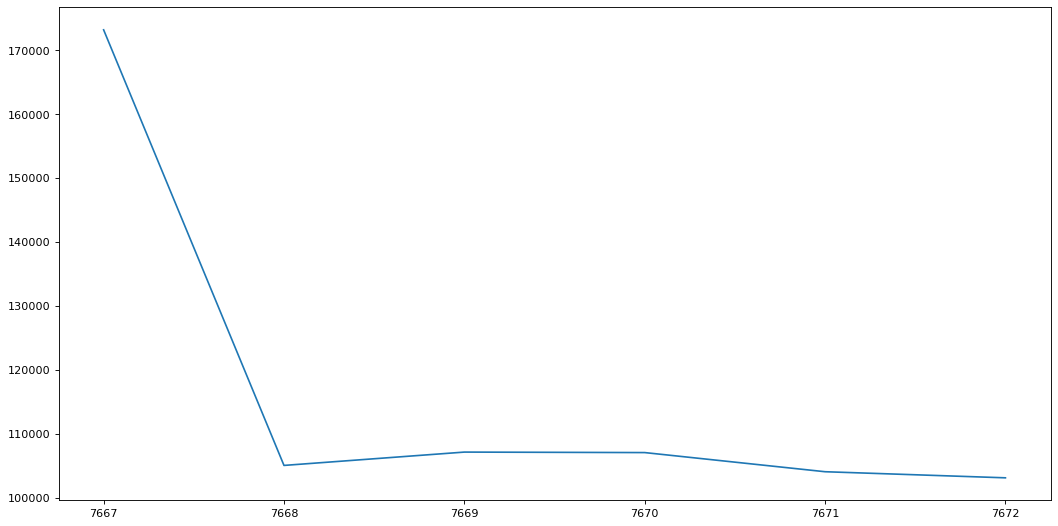

In [31]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df_ful[-6:])

* Splitting the data into testing and training, with 2/3 for training and 1/3 for testing:

X, y = df.drop('Close', axis=1), df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Shape of the data:

X_train.shape

Hyperparameter tuning using GridSearchCV and KerasClassifier

In [32]:
#def build_clf(unit):
  # creating the layers of the NN
    #ann = tf.keras.models.Sequential()
    #ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
    #ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
    #ann.add(tf.keras.layers.Dense(units=1))
    #ann.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
    #return ann

object of KerasClassifier class

In [33]:
#model_grid = KerasClassifier(build_fn=build_clf)

In [34]:
#params={'nb_epoch':[200, 100, 600],'unit':np.arange(4,44,8)}

#gs = GridSearchCV(estimator=model_grid, param_grid=params, cv=10, verbose=0)
# now fit the dataset to the GridSearchCV object. 
#gs = gs.fit(X, y)

In [35]:
#best_params=gs.best_params_
#accuracy=gs.best_score_

Creating a Model:

model = Sequential()

model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

Training the Model:

To find the optimal number of epochs, we use the EarlyStopping function:


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
#callbacks=[early_stop]

model.fit(x=X_train,y=y_train.values,validation_data=(X_test,y_test),
          verbose=0, batch_size=32, epochs=1000, callbacks=[early_stop])

Checking the model for overfitting:

losses = pd.DataFrame(model.history.history)
losses.plot()

Evaluation on Test Data:

predictions = model.predict(X_test)

print("Mean absolute error is", mean_absolute_error(y_test,predictions))
print("Mean squared error is", np.sqrt(mean_squared_error(y_test,predictions)))
print("The Variance explied by the models is", explained_variance_score(y_test,predictions))
print("The Average percentage error is", mean_absolute_error(y_test,predictions)/df['Close'].mean()*100)

Plot Our predictions vs Perfect predictions

plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,'r')

Min & Max errors:

errors = y_test.values.reshape(3012, 1) - predictions
print(min(errors), max(errors))

Distribution of the errors:

sns.distplot(errors, bins=50)